In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Can slow down but ensures determinism

set_seed(42)

import json
import matplotlib.pyplot as plt

from mobilenet import MobileNet
from data import get_train_valid_loader, get_test_loader

In [ ]:
def train_func(model, optimizer, criterion, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    return train_loss, train_accuracy

def eval(model, criterion, valid_loader, device):
    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    return valid_loss, valid_accuracy


In [3]:
batch_size = 128
data_dir = './data'
train_loader, valid_loader = get_train_valid_loader(data_dir=data_dir,batch_size=batch_size,augment=True,random_seed=42)
test_loader = get_test_loader(data_dir=data_dir, batch_size=batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
momentum = 0.9


Experiment 2: Training with cosine annealing learning rate
Epoch [1/300], Train Loss: 4.1411, Train Acc: 6.48%, Valid Loss: 3.7827, Valid Acc: 10.79%, Learning Rate: 0.049999
Epoch [11/300], Train Loss: 2.0770, Train Acc: 43.44%, Valid Loss: 2.2102, Valid Acc: 42.13%, Learning Rate: 0.049834
Epoch [21/300], Train Loss: 1.3389, Train Acc: 60.76%, Valid Loss: 1.9022, Valid Acc: 49.60%, Learning Rate: 0.049398
Epoch [31/300], Train Loss: 0.8491, Train Acc: 73.42%, Valid Loss: 2.1040, Valid Acc: 51.47%, Learning Rate: 0.048694
Epoch [41/300], Train Loss: 0.4495, Train Acc: 85.26%, Valid Loss: 2.3334, Valid Acc: 53.07%, Learning Rate: 0.047731
Epoch [51/300], Train Loss: 0.2480, Train Acc: 91.83%, Valid Loss: 2.5957, Valid Acc: 54.53%, Learning Rate: 0.046519
Epoch [61/300], Train Loss: 0.1387, Train Acc: 95.50%, Valid Loss: 2.7378, Valid Acc: 54.59%, Learning Rate: 0.045070
Epoch [71/300], Train Loss: 0.0936, Train Acc: 97.02%, Valid Loss: 2.9343, Valid Acc: 55.03%, Learning Rate: 0.043402

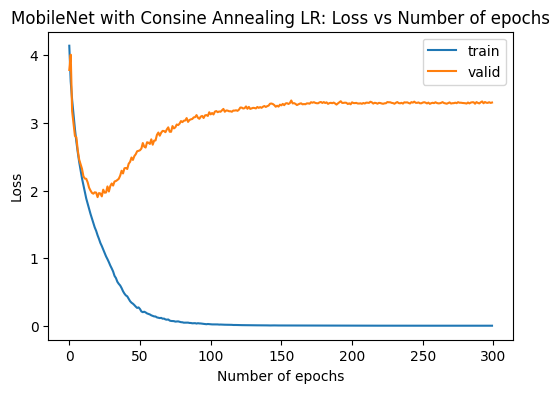

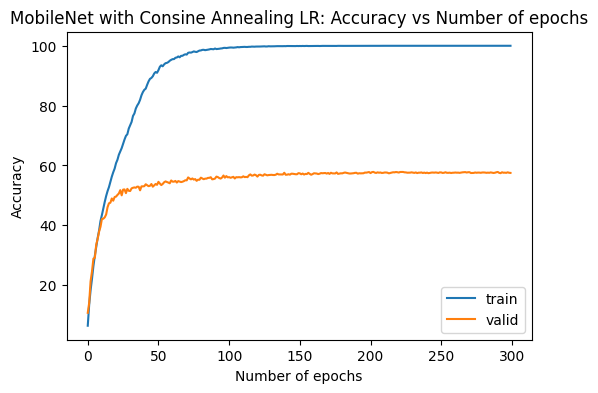

In [4]:
# Hyperparameters for the new experiments
num_epochs = 300
learning_rate = 0.05 # best learning rate from the previous experiment 

# Function to train with cosine annealing learning rate
def train_cosine_annealing(model, initial_lr, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        if epoch % 10 == 0 or epoch == num_epochs-1:
            
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, "
                  f"Valid Loss: {valid_loss:.4f}, "
                  f"Valid Acc: {valid_accuracy:.2f}%, "
                  f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
# Experiment 2: Train for 300 epochs with cosine annealing learning rate
print("Experiment 2: Training with cosine annealing learning rate")

model = MobileNet(num_classes=100, sigmoid_block_ind = []).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_losses, valid_losses, train_accuracies, valid_accuracies = train_cosine_annealing(
    model, learning_rate, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Consine Annealing LR")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_loss.png')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Consine Annealing LR")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_accuracy.png')
plt.show()


learning_curves = {"train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accuracies": train_accuracies,
                    "valid_accuracies": valid_accuracies
                    }

with open(f'learning_curves/cosine_annealing.json', 'w') as fp:
    json.dump(learning_curves, fp)

In [5]:
!git add .
!git commit -m "Auto-commit after Consine Annealing experiment"
!git push origin main  # Change "main" to your branch name

[main 755ca0f] Auto-commit after Consine Annealing experiment
 9 files changed, 647 insertions(+), 547 deletions(-)
 create mode 100644 ai6103_mobilenet_homework-cosine-annealing.ipynb
 rewrite ai6103_mobilenet_homework-weight-decay.ipynb (95%)
 create mode 100644 images/0.05_constant_lr_loss.png
 rewrite images/cosine_annealing_accuracy.png (99%)
 rewrite images/cosine_annealing_loss.png (99%)
 create mode 100644 learning_curves/cosine_annealing.json
 delete mode 100644 learning_curves/cosine_annealing_curves.json
Enumerating objects: 20, done.
Counting objects: 100% (20/20), done.
Delta compression using up to 128 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 179.30 KiB | 3.81 MiB/s, done.
Total 12 (delta 7), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (7/7), completed with 6 local objects.
To github.com:giangson19/ai6103_assignment.git
   5210b95..755ca0f  main -> main
